In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
import matplotlib.pyplot as plt

In [3]:

#-------------------------------1. Préparation des données------------------------------
# Créer un DataFrame
df = pd.read_csv('MRTSSM448USN.csv')
df.head()

,DATE,MRTSSM448USN
0,1992-01-01,6938.0
1,1992-02-01,7524.0
2,1992-03-01,8475.0
3,1992-04-01,9401.0
4,1992-05-01,9558.0


In [4]:

df = df.rename(columns={'DATE': 'date', 'MRTSSM448USN': 'sales'})
df.head()

,date,sales
0,1992-01-01,6938.0
1,1992-02-01,7524.0
2,1992-03-01,8475.0
3,1992-04-01,9401.0
4,1992-05-01,9558.0


In [5]:

# Assurez-vous que la colonne date est au format datetime
df['date'] = pd.to_datetime(df['date'])

# # Définir la colonne date comme index
# df.set_index('date', inplace=True)

# Afficher les 5 premières lignes du DataFrame
df.head()


,date,sales
0,1992-01-01,6938.0
1,1992-02-01,7524.0
2,1992-03-01,8475.0
3,1992-04-01,9401.0
4,1992-05-01,9558.0


In [6]:


#---------------------------------2. Prétraitement des données----------------------------------

# Normalisation des données
scaler = MinMaxScaler()
df['Sales_normalized'] = scaler.fit_transform(df[['sales']])

# Diviser les données en ensembles d'entraînement et de test
train_size = int(len(df) * 0.8)
test_size = len(df) - train_size
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]

print(f"Taille de l'ensemble d'entraînement : {len(train)}, Taille de l'ensemble de test : {len(test)}")


Taille de l'ensemble d'entraînement : 305, Taille de l'ensemble de test : 77


In [20]:

#--------------------------------3. Préparation des séquences pour le LSTM-------------------------

def create_sequences(data, sequence_length):
    sequences = []
    for i in range(len(data) - sequence_length):
        sequence = data[i : (i + sequence_length)]
        sequences.append(sequence)
    return np.array(sequences)

# Définir la longueur de la séquence temporelle
sequence_length = 12 # Vous pouvez ajuster cette valeur

# Créer les séquences pour l'entraînement
X_train = create_sequences(train['Sales_normalized'].values, sequence_length)
y_train = train['Sales_normalized'].values[sequence_length:]

X_test = create_sequences(test['Sales_normalized'].values, sequence_length)

y_test = test['Sales_normalized'].values[sequence_length:]


In [21]:

#-----------------------------------4. Création et entraînement du modèle LSTM----------------------------

# Créer le modèle LSTM
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(units=50))
model.add(Dense(units=1))

# Compiler le modèle
model.compile(optimizer='adam', loss='mean_squared_error')

# Entraîner le modèle
model.fit(X_train, y_train, epochs=100, batch_size=32)


Epoch 1/100
10/10 [==============================] - 6s 18ms/step - loss: 0.0838
Epoch 2/100
10/10 [==============================] - 0s 22ms/step - loss: 0.0202
Epoch 3/100
10/10 [==============================] - 0s 20ms/step - loss: 0.0136
Epoch 4/100
10/10 [==============================] - 0s 21ms/step - loss: 0.0116
Epoch 5/100
10/10 [==============================] - 0s 21ms/step - loss: 0.0113
Epoch 6/100
10/10 [==============================] - 0s 21ms/step - loss: 0.0105
Epoch 7/100
10/10 [==============================] - 0s 23ms/step - loss: 0.0105
Epoch 8/100
10/10 [==============================] - 0s 20ms/step - loss: 0.0102
Epoch 9/100
10/10 [==============================] - 0s 21ms/step - loss: 0.0100
Epoch 10/100
10/10 [==============================] - 0s 23ms/step - loss: 0.0099
Epoch 11/100
10/10 [==============================] - 0s 20ms/step - loss: 0.0100
Epoch 12/100
10/10 [==============================] - 0s 21ms/step - loss: 0.0096
Epoch 13/100
10/10 [=====

3/3 [==============================] - 2s 10ms/step - loss: 0.0298
Perte (Loss) : 0.02984839677810669
3/3 [==============================] - 2s 7ms/step


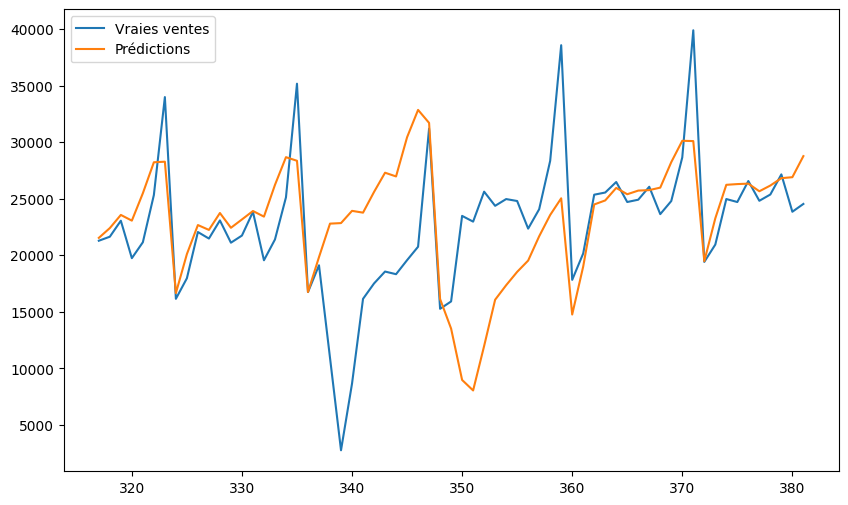

In [22]:

#-------------------------------5. Évaluation du modèle et prédictions--------------------------------

# Évaluation du modèle
loss = model.evaluate(X_test, y_test)
print(f'Perte (Loss) : {loss}')

# use cross validation to valuate the model




# Faire des prédictions
predicted_sales_normalized = model.predict(X_test)

# Inverser la normalisation pour obtenir les valeurs réelles
predicted_sales = scaler.inverse_transform(predicted_sales_normalized)

# Afficher les prédictions par rapport aux vraies valeurs
plt.figure(figsize=(10, 6))
plt.plot(test.index[sequence_length:], test['sales'].values[sequence_length:], label='Vraies ventes')
plt.plot(test.index[sequence_length:], predicted_sales, label='Prédictions')
plt.legend()
plt.show()